In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-image/train_images/train_1117.png
/kaggle/input/medical-image/train_images/train_0205.png
/kaggle/input/medical-image/train_images/train_1515.png
/kaggle/input/medical-image/train_images/train_1224.png
/kaggle/input/medical-image/train_images/train_1453.png
/kaggle/input/medical-image/train_images/train_1200.png
/kaggle/input/medical-image/train_images/train_1092.png
/kaggle/input/medical-image/train_images/train_0153.png
/kaggle/input/medical-image/train_images/train_0966.png
/kaggle/input/medical-image/train_images/train_1019.png
/kaggle/input/medical-image/train_images/train_0757.png
/kaggle/input/medical-image/train_images/train_1299.png
/kaggle/input/medical-image/train_images/train_0777.png
/kaggle/input/medical-image/train_images/train_0214.png
/kaggle/input/medical-image/train_images/train_0109.png
/kaggle/input/medical-image/train_images/train_0380.png
/kaggle/input/medical-image/train_images/train_0295.png
/kaggle/input/medical-image/train_images/train_0

In [2]:
import os
current_dir = os.getcwd()
print(current_dir)

/kaggle/working


In [3]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch
import numpy as np
import random


In [4]:
images_dirb ='../input/medical-image/train_images/' 
mask_dirb = '../input/medical-image/train_masks/'
data_dir= '../input/medical-image'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [6]:
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torchvision.transforms.functional as TF
import random
from PIL import Image
from torch.utils.data import Dataset

seed= 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


class MedicalImageData(Dataset):
    def __init__(self, image_paths, mask_paths, img_size=(256, 256)):  # Resizing to 256x256
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale for mask

        # Randomly apply the same transformations to both image and mask
        image, mask = self._random_transform(image, mask)

        # Convert image and mask to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = (mask * 255).long() # Convert mask to long tensor (class labels)

        return image, mask

    def _random_transform(self, image, mask):
        # Resize image and mask to 256x256
        image = TF.resize(image, self.img_size)
        mask = TF.resize(mask, self.img_size, interpolation=TF.InterpolationMode.NEAREST)  # Ensure nearest-neighbor for mask

        # Random rotation
        angle = random.uniform(-10, 10)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)  # Nearest-neighbor for mask

        # Random translation
        max_translate = 0.1 * np.array(self.img_size)  # 10% of image size
        translations = [random.uniform(-t, t) for t in max_translate]
        image = TF.affine(image, angle=0, translate=translations, scale=1, shear=0)
        mask = TF.affine(mask, angle=0, translate=translations, scale=1, shear=0, interpolation=TF.InterpolationMode.NEAREST)

        # Random brightness and contrast (for image only)
        image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
        image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))

        return image, mask


# Get list of image paths and corresponding mask paths
image_paths = [os.path.join(images_dirb, fname) for fname in os.listdir(images_dirb)]
mask_paths = [os.path.join(mask_dirb, fname) for fname in os.listdir(mask_dirb)]


# First split: 80% training, 20% temp (will be split into validation and test)
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)


# Create custom dataset instances for train and test sets
train_dataset = MedicalImageData(train_images, train_masks)
test_dataset = MedicalImageData(test_images, test_masks)




In [7]:

from torch.utils.data import DataLoader
# Load into DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, persistent_workers=False, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, persistent_workers=False, pin_memory=False)

0 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
1 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
2 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
3 torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


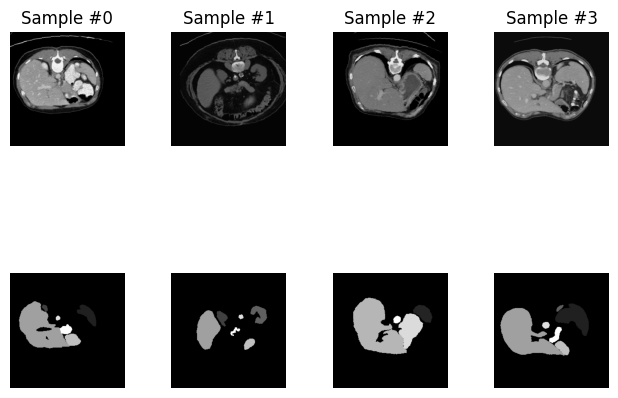

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i, (image,mask) in enumerate(train_dataset):
    print(i, image.shape, mask.shape)

    ax = plt.subplot(2, 4, i + 1)# 2 rows, 4 columns grid, first 4 positions for images
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    # Plot image
    ax.imshow(image.permute(1, 2, 0))  # Convert to HWC for plotting

    # Plot mask (grayscale)
    ax = plt.subplot(2, 4, i + 5)  # Plot mask in the second row
    ax.imshow(mask.squeeze(), cmap='gray')  # Squeeze to remove unnecessary dimension
    ax.axis('off')

    if i == 3:
        break
plt.show()

In [9]:
import torch
seed= 42
torch.manual_seed(seed)
import torch.nn as nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, dropout_prob)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode, dropout_prob=0.0):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels - out_channels, in_channels - out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels, dropout_prob)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=9, up_sample_mode='conv_transpose', dropout_prob=0.0):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64, dropout_prob)
        self.down_conv2 = DownBlock(64, 128, dropout_prob)
        self.down_conv3 = DownBlock(128, 256, dropout_prob)
        self.down_conv4 = DownBlock(256, 512, dropout_prob)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024, dropout_prob)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode, dropout_prob)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode, dropout_prob)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode, dropout_prob)
        self.up_conv1 = UpBlock(64 + 128, 64, self.up_sample_mode, dropout_prob)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        # Upsampling path
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        
        # Final Convolution
        x = self.conv_last(x)
        return x

Key Points
Weighted Sum: dice_weight is used to balance the contribution of each loss. You might want to adjust this based on your specific needs or dataset characteristics.

Flexibility: This combination allows for adjustments in how much you prioritize overlap versus classification accuracy.

General Performance: This can help improve general segmentation performance, especially in cases with varying class distributions.

By combining both losses, you harness the strengths of each to potentially improve model performance on challenging segmentation tasks. Adjust the weight dice_weight depending on your task and experiment with different values to see which balance works best for your dataset.

In [10]:
# class MixedLoss(nn.Module):
#     def __init__(self, dice_weight=0.5, smooth=1):
#         super(MixedLoss, self).__init__()
#         self.dice_weight = dice_weight
#         self.smooth = smooth
#         self.ce_loss = nn.CrossEntropyLoss()

#     def forward(self, inputs, targets):
#         # Compute Cross-Entropy Loss
#         ce_loss = self.ce_loss(inputs, targets)
        
#         # Compute Dice Loss
#         inputs = torch.softmax(inputs, dim=1)
#         targets_one_hot = nn.functional.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        
#         dice_loss = 0
#         for i in range(inputs.shape[1]):
#             inputs_flat = inputs[:, i].contiguous().view(-1)
#             targets_flat = targets_one_hot[:, i].contiguous().view(-1)

#             intersection = (inputs_flat * targets_flat).sum()
#             union = inputs_flat.sum() + targets_flat.sum()

#             dice = (2. * intersection + self.smooth) / (union + self.smooth)
#             dice_loss += 1 - dice
        
#         dice_loss /= inputs.shape[1]

#         # Combine both losses
#         return self.dice_weight * dice_loss + (1 - self.dice_weight) * ce_loss



class WeightedDiceLoss(nn.Module):
    def __init__(self, weights=None, smooth=1e-6):
        super(WeightedDiceLoss, self).__init__()
        self.weights = weights
        self.smooth = smooth

    def forward(self, preds, targets):
        # Apply softmax to the raw logits predictions
        preds = torch.softmax(preds, dim=1)  # Convert logits to probabilities
        
        # Ensure targets are in the correct shape for class-wise comparison
        B, C, H, W = preds.shape
        
        # Create one-hot encoding for targets
        one_hot_targets = torch.zeros_like(preds)
        for c in range(9):  # Assuming 9 classes
            one_hot_targets[:, c][targets == c] = 1

        dice_loss = 0.0
        
        for c in range(C):
            pred_flat = preds[:, c].view(B, -1)
            target_flat = one_hot_targets[:, c].view(B, -1)
            
            intersection = (pred_flat * target_flat).sum(1)
            union = pred_flat.sum(1) + target_flat.sum(1)
            
            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            
            if self.weights is not None:
                dice_score = dice_score * self.weights[c]
                
            dice_loss += (1 - dice_score).mean()
        
        return dice_loss / C

In [11]:
import torch.optim as optim
seed= 42
torch.manual_seed(seed)
# Initialize the model
model = UNet(in_channels=3, out_channels=9, up_sample_mode='conv_transpose', dropout_prob=0).to(device)

# Define the loss function
# criterion = MixedLoss(dice_weight=0.5)  # Adjust based on the number of classes and task
class_weights = torch.tensor([0.3, 0.7, 1.0, 1.0, 2.0, 0.5, 1.0, 1.5, 1.5])
class_weights = class_weights.to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = WeightedDiceLoss(weights=class_weights).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler (example: Reduce on Plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.7, 
                                                 patience=5, 
                                                 verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
def iou_per_class(outputs, targets, num_classes):
    """
    Calculate IoU for each class.

    Args:
        outputs (torch.Tensor): Predictions tensor with shape [batch_size, num_classes, height, width].
        targets (torch.Tensor): Ground truth tensor with shape [batch_size, height, width].
        num_classes (int): Number of classes.

    Returns:
        ious (list): List of IoUs for each class.
    """    
    # Apply softmax to get class probabilities
    _, preds = torch.max(outputs, dim=1)  # Shape: [batch_size, height, width]

    ious = []
    for i in range(num_classes):
        # Create binary masks for the current class, ensure they are on the correct device
        pred_mask = (preds == i).float().to(device)
        target_mask = (targets == i).float().to(device)

        # Compute intersection and union
        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum() - intersection

        # Compute IoU
        if union == 0:
            iou = torch.tensor(float('nan'), device=device)  # Avoid division by zero, ensure it's on the correct device
        else:
            iou = intersection / union

        ious.append(iou)
    
    return ious

def mean_iou(outputs, targets, num_classes):
    """
    Calculate mean IoU across all classes.

    Args:
        outputs (torch.Tensor): Predictions tensor with shape [batch_size, num_classes, height, width].
        targets (torch.Tensor): Ground truth tensor with shape [batch_size, height, width].
        num_classes (int): Number of classes.

    Returns:
        mean_iou (float): Mean IoU across all classes.
    """
    ious = iou_per_class(outputs, targets, num_classes)
    
    # Ensure ious is on the correct device
    ious_tensor = torch.stack(ious)  # Stack list to tensor, ensures they are all on the correct device
    mean_iou = torch.mean(ious_tensor)  # Calculate mean IoU
    
    return mean_iou.item()


In [13]:
import pandas as pd
import math

# Number of epochs
num_epochs = 500  # Set the number of epochs
current_best_val_loss = math.inf
count = 0
# Training loop
for epoch in range(num_epochs):
   
    model.train()  # Set the model to training mode
    tr_loss_values = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)  # Get model predictions
        # print("Outputs shape:", outputs.shape)
        # print("Targets shape:", targets.shape)
        targets = targets.squeeze(1) 


        # Compute loss
        loss = criterion(outputs, targets.long())
        num_classes = outputs.shape[1]
        ious_class = iou_per_class(outputs, targets, num_classes)
        miou = mean_iou(outputs, targets, num_classes)
        tr_loss_values += loss.item()

        # Backward pass
        loss.backward()  # Compute gradients
        # Optimization step
        optimizer.step()  # Update model parameters
        
    # Clear unused memory after each epoch
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()


    avg_tr_loss = tr_loss_values / len(train_loader) 
    scheduler.step(avg_tr_loss)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {tr_loss_values / len(train_loader):.4f}, Mean IoU: {miou:.4f}')
    print('Iou per class:')
    for idx, score in enumerate(ious_class):
        print(f'class {idx}: {score}')

    #validate
    model.eval()
    predictions = []
    val_loss_values = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model(inputs)  # Get model predictions
        # predictions.append(outputs) #collect the list of prediction
        # base_predictions = torch.cat(predictions, dim=0)
        # print("Outputs shape:", outputs.shape)
        # print("Targets shape:", targets.shape)
        targets = targets.squeeze(1) 
        

        # Compute loss
        loss = criterion(outputs, targets.long())
        num_classes = outputs.shape[1]
        miou = mean_iou(outputs, targets, num_classes)
        ious_class = iou_per_class(outputs, targets, num_classes)
        val_loss_values += loss.item()


    avg_val_loss = val_loss_values / len(test_loader) 

    # Print the average loss for the epoch
    print(f'Validation, Loss: {tr_loss_values / len(test_loader):.4f}, Mean IoU: {miou:.4f}')
    print('Iou per class:')
    for idx, score in enumerate(ious_class):
        print(f'class {idx}: {score}')

    if avg_val_loss <= current_best_val_loss:
        # Saving model
        best_wt_path = './best_wt.pt'
        torch.save(model.state_dict(),best_wt_path)
        current_best_val_loss = avg_val_loss
        print(f"Validation loss went down. Saving newer model at epoch: {epoch}")
        count = 0
    else:
        count+=1
    
    if count > 15: #early stopping
        print("early stopping")
        break

/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch [1/500], Loss: 0.9522, Mean IoU: 0.2687
Iou per class:
class 0: 0.8489542603492737
class 1: 0.29876089096069336
class 2: 0.13503386080265045
class 3: 0.21903569996356964
class 4: 0.0
class 5: 0.6603965163230896
class 6: 0.13223542273044586
class 7: 0.12390299886465073
class 8: 0.0
Validation, Loss: 3.7183, Mean IoU: 0.2322
Iou per class:
class 0: 0.8212347626686096
class 1: 0.3719237446784973
class 2: 0.08969942480325699
class 3: 0.09119466692209244
class 4: 0.0
class 5: 0.5514094829559326
class 6: 0.06765539944171906
class 7: 0.09654881805181503
class 8: 0.0
Validation loss went down. Saving newer model at epoch: 0
Epoch [2/500], Loss: 0.9177, Mean IoU: 0.2570
Iou per class:
class 0: 0.3042449653148651
class 1: 0.19363057613372803
class 2: 0.26675084233283997
class 3: 0.26210078597068787
class 4: 0.0275356937199831
class 5: 0.7839275002479553
class 6: 0.399139404296875
class 7: 0.07509607821702957
class 8: 0.00023532538034487516
Validation, Loss: 3.5835, Mean IoU: 0.1863
Iou per

In [14]:
# !pip install --no-index --find-links= /kaggle/input/segmentation_models/pytorch/default/1/segmentation_models/segmentation_models_pytorch-0.3.4-py3-none-any.whl
# !pip install --no-index --find-links= /kaggle/input/segmentation_models/pytorch/default/1/segmentation_models/pretrainedmodels-0.7.4.tar.gz
# !pip install --no-index --find-links= /kaggle/input/segmentation_models/pytorch/default/1/segmentation_models/efficientnet_pytorch-0.7.1.tar.gz
# !pip install --no-index --find-links= /kaggle/input/segmentation_models/pytorch/default/1/segmentation_models/timm-0.9.7-py3-none-any.whl


In [15]:
exit("Notebook execution stopped here.")